

# Exploratory Data Analysis  

  


In [ ]:
!pip install optuna

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from decimal import Decimal
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, log_loss, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import optuna

In [3]:
data = pd.read_parquet("C:/Users/shuti/Documents/Downloads/catB_train.parquet")
pd.set_option('display.max_rows', None)

target = 'f_purchase_lh'

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17992 entries, 19550 to 15795
Columns: 304 entries, clntnum to f_purchase_lh
dtypes: float64(44), int64(46), object(214)
memory usage: 41.9+ MB


### Inspect unique values of each column in data

In [5]:
for column in data.columns:
    print(f"Unique values in '{column}': {data[column].unique()}")

Unique values in 'clntnum': ['91b546e924' '896bae548c' 'f364439ae6' ... '6e44cfb3e7' 'dd4e362f9f'
 '3788d06ec7']
Unique values in 'race_desc': ['Chinese' 'Others' 'Indian' None 'Malay']
Unique values in 'ctrycode_desc': ['Singapore' 'Not Applicable' 'Malaysia' 'United Kingdom'
 'Brunei Darussalam' 'Hong Kong' 'Indonesia' 'Philippines' 'Thailand'
 'Australia' None 'United Arab Emirates' 'Japan' 'Spain' 'China'
 'Taiwan (R.O.C)' 'United States' 'Denmark' 'Unknown Country Code'
 'South Africa' 'Sweden' 'Ireland' 'New Zealand' 'Netherlands' 'Italy'
 'Bosnia-Herzegovina' 'Canada']
Unique values in 'clttype': ['P' 'G' 'C']
Unique values in 'stat_flag': ['ACTIVE' 'LAPSED' 'MATURED']
Unique values in 'min_occ_date': ['2017-10-31' '2007-05-23' '2019-08-31' ... '2015-04-03' '2012-07-05'
 '1990-03-20']
Unique values in 'cltdob_fix': ['1974-05-09' '1979-11-11' '1976-01-28' ... '1948-12-16' '1967-12-06'
 '1970-05-15']
Unique values in 'cltsex_fix': ['Female' 'Male' None]
Unique values in 'flg_subst

## Inspecting the policies
There are 5 types of policies:
1. general insurance (gi)
2. group policies (grp)
3. investment-linked policies (inv)
4. life or health insurance (lh)
5. long-term care insurance (ltc)

The suffixes (e.g. 42e115, 1280bf) are unique identifiers for the specific insurance products. 

Based on observation of the above + description in NUS-SDS-Datathon GitHub, there are different types of policies and under each of them are specific policies with their unique identifiers. We have also observed a specific policy with identifier '32c74c' that does not seem to be under any policy type although it is found in:  
ape_32c74c                                  float64  
sumins_32c74c                               float64  
prempaid_32c74c                             float64  
lapse_ape_32c74c                            float64  
n_months_since_lapse_32c74c                 float64  
f_ever_bought_32c74c                          int64  
n_months_last_bought_32c74c                   int64  

  
'14cb37' also does not seem to be under any policy type although it is found in:  
flg_hlthclaim_14cb37_ever                   float64  
recency_hlthclaim_14cb37                    float64


In [6]:
def extract_unique_identifiers(columns):
    policy_types = ['gi', 'grp', 'inv', 'lh', 'ltc']
    identifiers = {ptype: set() for ptype in policy_types}

    for col in columns:
        for ptype in policy_types:
            match = re.search(f"{ptype}_([a-zA-Z0-9]+)", col)
            if match:
                identifiers[ptype].add(match.group(1))

    return identifiers

unique_identifiers = extract_unique_identifiers(data.columns)
unique_identifiers['gi'].remove('claim')

for policy_type, ids in unique_identifiers.items():
    print(f"Unique identifiers for {policy_type} policies: {ids}")

Unique identifiers for gi policies: {'42e115', 'a10d1b', '058815', '29d435', '856320'}
Unique identifiers for grp policies: {'fe5fb8', 'caa6ff', '1581d7', 'e91421', '6a5788', '70e1dd', '22decf', '945b5a', 'e04c3a', 'fd3bfb', '6fc3e6', '9cdedf', '94baec', 'de05ae'}
Unique identifiers for inv policies: {'e9f316', 'dcd836'}
Unique identifiers for lh policies: {'947b15', '839f8a', 'e22a6a', '507c37', 'f852af', 'd0adeb'}
Unique identifiers for ltc policies: {'43b9d5', '1280bf'}


## Inspect columns containing 'clmcon'
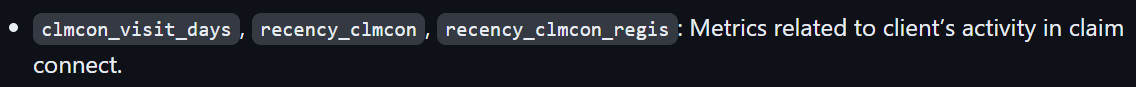
Columns containing 'clmcon' are metrics related to client’s activity in claim connect. We have searched online and found out that claim connect is Singlife's online platform for clients to submit their insurance claims

In [7]:
clmcon = [col for col in data.columns if 'clmcon' in col]
clmcon

['clmcon_visit_days', 'recency_clmcon', 'recency_clmcon_regis']

### Inspect columns related to household and population size 
![image.png](attachment:image.png

By inspecting these 4 columns, we found out that 'hh_size' contains values that can be derived from substracting 'pop_20' by 'hh_20'. Also, 'hh_size_est' is the rounded-off values of 'hh_size', except if the value in 'hh_size' exceeds 4.0, 'hh_size_est' will capture it as '>4'

In [8]:
subset = data[['hh_20', 'pop_20', 'hh_size', 'hh_size_est']].head(20)
print(subset)

      hh_20 pop_20   hh_size hh_size_est
19550   144    202  1.402778           1
4600    153    480  3.137255           3
13337    62    179  2.887097           3
15074     1      4  4.000000           4
19724   114    478  4.192982          >4
14717   138    477  3.456522           3
6307    131    418  3.190840           3
4168    233    758  3.253219           3
169     109    261  2.394495           2
11816    58     77  1.327586           1
14245   107    328  3.065421           3
4618    125    455  3.640000           4
11928  None   None       NaN        None
11195    68    186  2.735294           3
6492   None   None       NaN        None
10520    84    242  2.880952           3
18743   102    299  2.931373           3
15299    60    338  5.633333          >4
17470   221    669  3.027149           3
17726    72    151  2.097222           2


### Check for duplicate values in 'clntnum' to ensure that there are no repeated clients

In [9]:
duplicates = data['clntnum'].duplicated()
num_duplicates = duplicates.sum()
any_duplicates = duplicates.any()

print(f"Number of duplicate values in 'clntnum': {num_duplicates}")
print(f"Are there any duplicate values in 'clntnum'? {'Yes' if any_duplicates else 'No'}")

Number of duplicate values in 'clntnum': 0
Are there any duplicate values in 'clntnum'? No


### Count the number & percentage of null values in every column in data

In [10]:
null_counts = data.isnull().sum()
total_rows = len(data)
null_percentage = (null_counts / total_rows) * 100
null_stats = pd.DataFrame({'Number of Nulls': null_counts, 'Percentage of Nulls': null_percentage})

null_stats = null_stats.sort_values(by='Percentage of Nulls', ascending=False)
null_stats.head(20)

,Number of Nulls,Percentage of Nulls
giclaim_cnt_unsuccess,17992,100.000000
giclaim_cnt_success,17992,100.000000
flg_gi_claim_856320_ever,17992,100.000000
flg_gi_claim_42e115_ever,17992,100.000000
flg_gi_claim_058815_ever,17992,100.000000
flg_gi_claim_29d435_ever,17992,100.000000
recency_giclaim_success,17992,100.000000
recency_giclaim_unsuccess,17992,100.000000
flg_hlthclaim_839f8a_ever,17707,98.415963
recency_hlthclaim_839f8a,17707,98.415963


### Number & percentage of 'None' values in each column

In [11]:
none_counts = data.apply(lambda x: (x == 'None').sum())
total_rows = len(data)
none_percentage = (none_counts / total_rows) * 100
none_stats = pd.DataFrame({'Number of None Entries': none_counts, 'Percentage of None Entries': none_percentage})

# Sort by 'Percentage of None Entries'
none_stats = none_stats.sort_values(by='Percentage of None Entries', ascending=False)
none_stats.head(20)

,Number of None Entries,Percentage of None Entries
cltdob_fix,22,0.122277
min_occ_date,10,0.055580
clntnum,0,0.000000
n_months_since_lapse_grp_70e1dd,0,0.000000
n_months_since_lapse_32c74c,0,0.000000
n_months_since_lapse_lh_947b15,0,0.000000
n_months_since_lapse_lh_f852af,0,0.000000
n_months_since_lapse_grp_e91421,0,0.000000
n_months_since_lapse_grp_94baec,0,0.000000
n_months_since_lapse_grp_fe5fb8,0,0.000000


### Number & percentage of null values in each row

In [12]:
null_counts_per_row = data.isnull().sum(axis=1)
null_percentage_per_row = (null_counts_per_row / len(data.columns)) * 100
null_stats_per_row = pd.DataFrame({'Number of Nulls per Row': null_counts_per_row, 
                                   'Percentage of Nulls per Row': null_percentage_per_row})

null_stats_per_row_sorted = null_stats_per_row.sort_values(by='Percentage of Nulls per Row', ascending=False)
print(null_stats_per_row_sorted)

       Number of Nulls per Row  Percentage of Nulls per Row
13395                      109                    35.855263
584                        109                    35.855263
9528                       109                    35.855263
1036                       109                    35.855263
6321                       109                    35.855263
17995                      109                    35.855263
4823                       109                    35.855263
16365                      109                    35.855263
14344                      109                    35.855263
12058                      109                    35.855263
14082                      109                    35.855263
4177                       109                    35.855263
19489                      109                    35.855263
16012                      109                    35.855263
13243                      109                    35.855263
4622                       109          

## Correlation Analysis for numerical columns 
Select only numerical columns for correlation analysis

In [13]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numerical_cols].corr()
print(correlation_matrix)

                                   flg_substandard  \
flg_substandard                           1.000000   
flg_is_borderline_standard                0.089340   
flg_is_revised_term                       0.005822   
flg_is_rental_flat                       -0.020403   
flg_has_health_claim                      0.069039   
flg_has_life_claim                        0.022741   
flg_gi_claim                              0.017097   
flg_is_proposal                           0.022480   
flg_with_preauthorisation                 0.027690   
flg_is_returned_mail                     -0.002559   
is_consent_to_mail                       -0.018012   
is_consent_to_email                      -0.015374   
is_consent_to_call                       -0.037448   
is_consent_to_sms                        -0.030111   
is_valid_dm                               0.109852   
is_valid_email                            0.081269   
is_housewife_retiree                      0.004386   
is_sg_pr                    

### Finding pairs with a high correlation of more than 0.95

In [14]:
highly_correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        correlation_value = abs(correlation_matrix.iloc[i, j])
        
        if correlation_value > 0.95:
            col_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_value)
            highly_correlated_pairs.append(col_pair)

for pair in highly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

f_ever_bought_c4bda5 and f_hold_c4bda5: Correlation = 0.975195936874282
f_ever_bought_ltc and f_hold_ltc: Correlation = 0.9887701291463121
f_ever_bought_ltc_43b9d5 and f_hold_ltc: Correlation = 0.9742160905620069
f_ever_bought_ltc_43b9d5 and f_ever_bought_ltc: Correlation = 0.9804173015721356
f_ever_bought_inv_e9f316 and f_hold_c4bda5: Correlation = 0.975195936874282
f_ever_bought_inv_e9f316 and f_ever_bought_c4bda5: Correlation = 1.0
recency_hlthclaim_success and recency_hlthclaim: Correlation = 0.9704026539673024
recency_hlthclaim_14cb37 and recency_hlthclaim: Correlation = 0.9812371385991749
recency_hlthclaim_14cb37 and recency_hlthclaim_success: Correlation = 0.9532843709992136
